In [112]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

%matplotlib inline

#Stop warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [113]:
data = pd.read_csv('ATM_Training.csv')

In [114]:
data.head()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
0,10.18,10,1,0,0,0,72.750556
1,9.74,10,1,1,0,0,66.720482
2,0.96,2,0,0,0,1,19.189516
3,9.58,9,1,1,0,1,67.388669
4,1.03,4,0,1,0,1,15.813127


# EDA

In [115]:
#I'll leave this to you if that's okay

In [116]:
for x in list(data):
    print('The variable type of ', x, ' is',data[x].dtype)

The variable type of  Shops  is float64
The variable type of  ATMs  is int64
The variable type of  Downtown  is int64
The variable type of  Weekday  is int64
The variable type of  Center  is int64
The variable type of  High  is int64
The variable type of  Withdraw  is float64


Downtown, Weekday, Center, and high are dummy variables.

Shops, ATMs, and withdraw are continuous variables.

In [117]:
#Only worthwhile to look at shops, ATMs, and withdraw
data.skew()

Shops      -0.877958
ATMs       -0.318768
Downtown   -0.883353
Weekday    -0.947692
Center      2.622120
High        0.864683
Withdraw   -0.772358
dtype: float64

In [118]:
data.mean()

Shops        7.316373
ATMs         7.937455
Downtown     0.702000
Weekday      0.714091
Center       0.102455
High         0.301591
Withdraw    54.652818
dtype: float64

In [119]:
data.median()

Shops        9.890000
ATMs         9.000000
Downtown     1.000000
Weekday      1.000000
Center       0.000000
High         0.000000
Withdraw    68.240749
dtype: float64

# Model Construction

In [120]:
#By test, I refer to the validation set in which we will test our models on.

final_train = data.sample(frac=0.6, random_state=450411920)
final_test = data[data.index.isin(final_train.index)==False]
#Now we have final train/test which only has predictors whilst y_train/test are the response
y_train = final_train.pop('Withdraw')
y_test = final_test.pop('Withdraw')

You can see more information about the models I use in this: http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

# Hyperparameter Tuning

Now we try to tune the hyperparameter in our models, we use this package called randomizedsearchcv.

This allows us to try out different hyperparameters.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

In [121]:
#In order to store the results from our models
modelname = []
models = []

In [122]:
#Standardising the data
scaler = StandardScaler()
scaler.fit(final_train)
train_scale = scaler.transform(final_train)
scaler.fit(final_test)
test_scale = scaler.transform(final_test)

## KNN

In [123]:
#Try setting from 1 - 25 neighbors
k_range = range(1, 25)

# we create a list. This allows us to see whether we should weigh all neighbours equally or weigh closer ones more
weight_options = ['uniform', 'distance']

In [124]:
#Creating the objects necessary for us to try cross-validation in order to locate best hyperparameters
param_dist = dict(n_neighbors=k_range, weights=weight_options)
knn = KNeighborsRegressor()
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='neg_mean_squared_error', n_iter=10, random_state=5)

In [125]:
#Fitting the model and testing out random hyperparameters. This saves on computation time
knnopt = rand.fit(final_train, y_train)

In [126]:
# examine the best model
print('MSE of this model is %.3f'%np.negative(rand.best_score_))
print('Best parameters from this is ',rand.best_params_)
print('This is the best KNN estimator', rand.best_estimator_)
models.append(knnopt)
modelname.append('KNN')

MSE of this model is 0.479
Best parameters from this is  {'weights': 'distance', 'n_neighbors': 9}
This is the best KNN estimator KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='distance')


In [129]:
#Now constructing a graph for this
k_range = range(1, 25)

# list of scores from k_range
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsRegressor with k neighbours
    knn = KNeighborsRegressor(n_neighbors=k, weights = 'uniform')
    # 3. obtain cross_val_score for KNeighborsRegressor with k neighbours
    scores = cross_val_score(knn, final_train, y_train, cv=10, scoring='neg_mean_squared_error')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
print(k_scores)

[-0.62975447467504286, -0.49265331541510449, -0.47201821877027417, -0.48343268344064799, -0.51228980857997686, -0.5482003247759184, -0.58442889195058823, -0.64126882365103521, -0.69626566178245475, -0.75309255703045574, -0.8439416629723302, -0.92346914690549986, -0.99552476713283689, -1.0576872512738387, -1.1253266265406536, -1.2075369939491591, -1.2937798170150558, -1.3819374370122393, -1.4721009238087881, -1.5475567132612265, -1.6308032455387997, -1.694247371502867, -1.7801438833549124, -1.859940424471676]


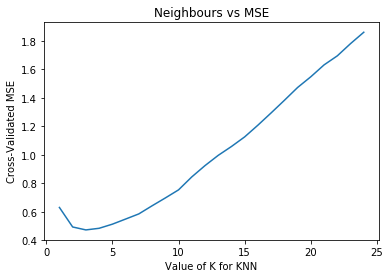

In [130]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
#remember that MSE is negative due to implementation in python, so we take negative
k_scores = np.negative(k_scores)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.title('Neighbours vs MSE')

# Decision Tree

In [131]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "min_samples_leaf": range(1, 9),
              "criterion": ["mse", "mae"]}

# Instantiate a Decision Tree regressor: tree
tree = DecisionTreeRegressor(random_state=450411920)

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree,param_dist, cv=10, scoring='neg_mean_squared_error', n_iter=10, random_state=5)

#Fitting the model and testing out random hyperparameters. This saves on computation time
treeopt = tree_cv.fit(final_train, y_train)


In [132]:
# examine the best model
print('MSE of this model is %.3f'%np.negative(tree_cv.best_score_))
print('Best parameters from this is ',tree_cv.best_params_)
print('This is the best Decision Tree estimator', tree_cv.best_estimator_)
models.append(tree_cv)
modelname.append('Decision Tree')

MSE of this model is 0.375
Best parameters from this is  {'min_samples_leaf': 3, 'max_depth': None, 'criterion': 'mse'}
This is the best Decision Tree estimator DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=450411920, splitter='best')


# Random Forest

In [133]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "min_samples_leaf": range(4, 9),
              "criterion": ["mse", "mae"]}

# Instantiate a Extremely Random Forest regressor: randext
randFor = RandomForestRegressor(random_state=450411920)

# Instantiate the RandomizedSearchCV object: randFor_cv
randFor_cv = RandomizedSearchCV(randFor,param_dist, cv=10, scoring='neg_mean_squared_error', n_iter=10, random_state=5)

#Fitting the model and testing out random hyperparameters. This saves on computation time
optrand = randFor_cv.fit(final_train, y_train)


In [134]:
# examine the best model
print('MSE of this model is %.3f'%np.negative(randFor_cv.best_score_))
print('Best parameters from this is ',randFor_cv.best_params_)
print('This is the best Random Forest estimator', randFor_cv.best_estimator_)
models.append(randFor_cv)
modelname.append('Random Forest')

MSE of this model is 0.347
Best parameters from this is  {'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'mse'}
This is the best Random Forest estimator RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=450411920, verbose=0,
           warm_start=False)


# Gradient Boosting

In [135]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"loss": ["huber", "ls"],
              "n_estimators": range(300,550,50),
              "learning_rate": [0.1],
              "min_samples_split" : [2,4],
              "min_samples_leaf" : range(1,3)
              }

# Instantiate a GB boosting classifier: randGB
randGB = GradientBoostingRegressor()

# Instantiate the RandomizedSearchCV object: randGB_cv
randGB_cv = RandomizedSearchCV(randGB,param_dist, cv=10, scoring='neg_mean_squared_error', n_iter=10, random_state=5)

#Fitting the model and testing out random hyperparameters. This saves on computation time
optgb = randGB_cv.fit(final_train, y_train)


In [136]:
# examine the best model
print('MSE of this model is %.3f'%np.negative(randGB_cv.best_score_))
print('Best parameters from this is ',randGB_cv.best_params_)
print('This is the best GradientBoost estimator', randGB_cv.best_estimator_)
models.append(randGB_cv)
modelname.append('Gradient Boost')

MSE of this model is 0.266
Best parameters from this is  {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 2, 'loss': 'ls', 'learning_rate': 0.1}
This is the best GradientBoost estimator GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


# LASSO

In [137]:
#LASSO
lasso = Lasso(alpha = 1)
optlasso = lasso.fit(final_train, np.ravel(y_train)) 
modelname.append('LASSO')
models.append(optlasso)

# Ridge

In [138]:
rg = Ridge(alpha = 10)
rigopt = rg.fit(final_train, y_train)
modelname.append('Ridge')
models.append(rigopt)

#Need to standardise features later on

In [139]:
#Generates us a table for results with hyperparameter optimised models
def getResultTable(rows, modelsUsed):
    columns=['R-Square', 'MSE',]
    results=pd.DataFrame(0.0, columns=columns, index=rows)
    predictions = []
    for clf in modelsUsed:
        pred = clf.predict(final_test)
        predictions.append(pred)
        
    for row,pred in zip(range(0,len(rows)),predictions):
        
        results.iloc[row,0] = r2_score(y_test,pred)
        results.iloc[row,1] = mean_squared_error(y_test,pred)
        
    return results.round(3)

In [140]:
getResultTable(modelname,models)

,R-Square,MSE
KNN,0.999,0.575
Decision Tree,0.999,0.371
Random Forest,0.999,0.344
Gradient Boost,1.000,0.263
LASSO,0.978,14.019
Ridge,0.990,6.129
